## Model for Sepsis Risk Categorization for Comorbidity Subgroups

#### Import necessary modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

#### Read neccessary files from preprocessed data & clean data

In [2]:
sofa_score = pd.read_csv('sofa_scores.csv')

In [3]:
all_subgroups = pd.read_csv('all_subgroups.csv')
#all_subgroups = all_subgroups[['subject_id', 'hadm_id', 'subgroup', 'rounded_age']]
temp = pd.read_csv('chartevents_temp_cleaned.csv')
temp = temp[temp['hadm_id'].isin(all_subgroups['hadm_id'].value_counts().index)][['hadm_id', 'Final_Temperature_F', 'charttime']]
#temp = temp[temp['charttime'].isin(all_subgroups['charttime'].value_counts().index)][['hadm_id', 'Final_Temperature_F', 'charttime']]
bp = pd.read_csv('chartevents_bp_cleaned.csv')
bp = bp[bp['hadm_id'].isin(all_subgroups['hadm_id'].value_counts().index)][['hadm_id', 'Combined_Blood_Pressure', 'charttime']].dropna()
def impute(heart_rate, max_rate):
    if pd.isna(heart_rate) == True:
        return max_rate
    else:
        return heart_rate
heart_rate = pd.read_csv('chartevents_hr_cleaned.csv')
heart_rate['heart_rate'] = heart_rate.apply(lambda x: impute(x["Heart Rate"], x["Heart rate Alarm - High"]), axis=1)
heart_rate = heart_rate[['hadm_id', 'charttime', 'heart_rate']]
o2_state = pd.read_csv('chartevents_o2sat.csv')
o2_state = o2_state[['hadm_id', 'charttime', 'SpO2']]
respiritory_rate = pd.read_csv('chartevents_rr_cleaned.csv')
respiritory_rate = respiritory_rate[['hadm_id', 'charttime', 'RespiratoryRate_combined']]
white_blood_cell = pd.read_csv('chartevents_wbc_cleaned.csv')
white_blood_cell = white_blood_cell[['hadm_id', 'charttime', 'WBC_combined', 'subject_id']]

In [4]:
model_subgroups = all_subgroups[['subject_id', 'hadm_id', 'subgroup', 'rounded_age']]

#### Merge vitals with comorbidity composition 

In [5]:
df = model_subgroups.merge(bp, on = 'hadm_id', how = 'outer')

In [6]:
df = df.merge(temp, on = ['charttime', 'hadm_id'], how = 'left')

In [7]:
df = df.merge(heart_rate, on = ['charttime', 'hadm_id'], how = 'left')


In [8]:
df = df.merge(respiritory_rate, on = ['charttime', 'hadm_id'], how = 'left')

In [9]:
df = df.merge(o2_state, on = ['charttime', 'hadm_id'], how = 'left')

In [10]:
df = df.dropna()

#### Encode Date

In [11]:

df['date'] = pd.to_datetime(df['charttime']).dt.date
df['charttime'] = pd.to_datetime(df['charttime'])

In [12]:
df.isna().sum()

subject_id                  0
hadm_id                     0
subgroup                    0
rounded_age                 0
Combined_Blood_Pressure     0
charttime                   0
Final_Temperature_F         0
heart_rate                  0
RespiratoryRate_combined    0
SpO2                        0
date                        0
dtype: int64

#### Encode Number of Admissions per Patient

In [13]:
#accounts for readmission 
df['hadm_number'] = df.groupby('subject_id')['hadm_id'].rank(method='dense').astype(int)

#### Calculate Number of Hours per Patient per Admission

In [14]:
df_sorted = df.sort_values(by=['subject_id', 'hadm_id', 'charttime'])

# Define a function to assign hours
def assign_hours(group):
    group['hours_in_hospital'] = (group['charttime'] - group['charttime'].iloc[0]).dt.total_seconds() / 3600
    return group

# Apply the function to each group of subject_id and hadm_id
df_with_hours = df_sorted.groupby(['subject_id', 'hadm_id']).apply(assign_hours)

# Convert hours_in_hospital to integers
df_with_hours['hours_in_hospital'] = df_with_hours['hours_in_hospital'].astype(int)

# Display the DataFrame with the new column
df_with_hours = df_with_hours.reset_index(drop = True)

In [15]:
import seaborn as sns

#### Create Sepsis Risk Categories Based on Sepsis Score

In [16]:
def groups(x):
    if 0<=x<=4:
        return 0 
    elif 5<=x<=11:
        return 1 
    else:
        return 2

In [17]:
sofa_score = sofa_score[['hadm_id', 'sofa']]

final_df = df_with_hours.merge(sofa_score, on = 'hadm_id', how = 'inner')

In [18]:
final_df['group'] = final_df['sofa'].apply(lambda x: groups(x))

#### Split Data into Subgroups

In [19]:
subgroup_1 = final_df[final_df['subgroup'] == 1]
subgroup_2 = final_df[final_df['subgroup'] == 2]
subgroup_3 = final_df[final_df['subgroup'] == 3]
subgroup_4 = final_df[final_df['subgroup'] == 4]
subgroup_5 = final_df[final_df['subgroup'] == 5]
subgroup_6 = final_df[final_df['subgroup'] == 6]
subgroup_7 = final_df[final_df['subgroup'] == 7]

#### This code was used to find hyperparameteres for subgroups. Subgroup hyperparameters are now tuned so don't run this. 

In [67]:
# X = subgroup_1.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
# y = subgroup_1['group']

In [68]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {'bootstrap': [True],
#  'max_depth': [90, 100, 500, 1000],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4, 10],
#  'min_samples_split': [ 1, 5, 10],
#  'n_estimators': [100, 600, 1000]}
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  34.5s


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  34.5s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=1000; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  34.9s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=1000; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  56.8s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=1000; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  57.5s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.7s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  57.5s
[CV] END bootstrap=True, max_depth=90, max_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.8s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  33.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_fe

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  32.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.9s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  33.9s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.7s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  32.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=90, max_fe

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1000; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_feat

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  54.7s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  53.8s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.3s
[CV] END bootstrap=True, max_depth=90, 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  54.9s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  54.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  32.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  55.4s
[CV] END bootstrap=True, max_depth=90, m

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=  28.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=  28.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  34.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=  28.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  34.5s
[CV] END bootstrap=True, max_depth=90,

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  31.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  32.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=  29.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=  47.3s
[CV] END bootstrap=True, max_depth=100,

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  55.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  53.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.9s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  55.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  57.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  53.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_dept

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=  28.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=  48.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  58.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.3s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  52.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  53.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=  47.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  32.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  34.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.7s
[CV] END bootstrap=True, max_depth=

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  32.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  34.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  31.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.9s
[CV] END bootstrap=True, max_depth=10

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  55.8s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.3s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  52.9s
[CV] END bootstrap=True, max_depth

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  55.6s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  54.0s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  52.4s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  55.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  54.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=500, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=1000; total time=   0.2s
[CV] END bootstrap=True, max_dept

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=1000; total time=   0.2s
[CV] END bootstrap=True, max_depth=500, 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.3s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  52.8s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  33.0s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.7s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  34.4s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.8s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  32.3s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.5s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  57.3s
[CV] END bootstrap=True, max_depth=10

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=  47.6s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=  28.9s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=  28.4s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.8s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  35.0s
[CV] END bootstrap=True, max_d

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  33.4s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  33.8s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  32.4s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  52.8s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  52.9s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  55.5s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  53.9s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.7s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=  28.4s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=  29.0s
[CV] END bootstrap=True

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  52.6s
[CV] END bootstrap=True, max_depth=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=  47.5s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  54.9s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  56.8s
[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  52.7s
[CV] END bootstrap=True, 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  56.2s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=4, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=4, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=4, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=4, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=4, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=4, min_samples_split=1, n_estimators=600; total time=   0.1s
[CV] END bootstrap=True, max_dept

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.70071469 0.70566038 0.70531732
 0.69722699 0.7011721  0.70072899        nan        nan        nan
 0.69732704 0.70102916 0.70207261 0.69606918 0.69708405 0.69792739
        nan        nan        nan 0.69108062 0.6943825  0.69535449
 0.6915952  0.69526872 0.69476844        nan        nan        nan
 0.68600629 0.68856489 0.68910806 0.68522013 0.68722127 0.68960835
        nan        nan        nan 0.70167238 0.70533162 0.70627501
 0.69802744 0.70087193 0.70052887        nan        nan        nan
 0.69854202 0.70197256 0.70180103 0.69498285 0.69728416 0.69751286
        nan        nan        nan 0.69426815 0.69518296 0.6948685
 0.69122356 0.69491138 0.69471126        nan        nan        nan
 0.68614923 0.68799314 0.68903659 0.68572041 0.68819325 0.6880932
        nan        nan        nan 0.70062893 0.70564608 0.7

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [90, 100, 500, 1000],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [1, 5, 10],
                         'n_estimators': [100, 600, 1000]},
             verbose=2)

In [71]:
# sum(grid_search.predict(X_test) == y_test)/len(y_test)

0.7025728987993138

In [72]:
# grid_search.best_params_

{'bootstrap': True,
 'max_depth': 1000,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

[CV] END bootstrap=True, max_depth=1000, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1000; total time=  47.7s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  33.3s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=  33.8s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=1000, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  53.8s
[CV] END bootstrap=True, 

In [22]:
#subgroup 1 
X = subgroup_1.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_1['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_1 = RandomForestClassifier(bootstrap = True,
 max_depth = 1000,
 max_features =  'sqrt',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_1.fit(X_train, y_train)
predictions_1 = rf_sub_1.predict(X_test)
y_test_1 = y_test
print(sum(rf_sub_1.predict(X_test) == y_test)/len(y_test))

0.7546598056032018


In [23]:
rf_sub_1.feature_importances_

array([0.11857364, 0.12638327, 0.09543057, 0.05906189, 0.11663509,
       0.06717254, 0.17442583, 0.24231718])

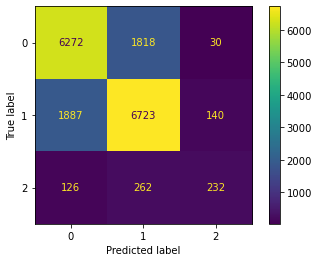

In [83]:
cm = confusion_matrix(y_test_1, predictions_1, labels=rf_sub_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_1.classes_)
disp.plot()

plt.show()

In [84]:
subgroup_1_predictions = rf_sub_1.predict(subgroup_1.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [85]:
subgroup_1['predictions'] = subgroup_1_predictions

/tmp/ipykernel_2630/2099966833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgroup_1['predictions'] = subgroup_1_predictions


In [86]:
print(sum(rf_sub_1.predict(X_test) == y_test)/len(y_test))

0.7562607204116638


In [87]:
subgroup_1.merge(all_subgroups[all_subgroups['subgroup'] == 1], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
       'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
       'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
       'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_1_predictions.csv')

In [24]:
subgroup_2_sample = subgroup_2.sample(frac = 0.3)

In [25]:
#subgroup 2
X = subgroup_2_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_2_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_2 = RandomForestClassifier(bootstrap = True,
 max_depth = 90,
 max_features =  'auto',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  600)
rf_sub_2.fit(X_train, y_train)
predictions_2 = rf_sub_2.predict(X_test)
y_test_2 = y_test
print(sum(rf_sub_2.predict(X_test) == y_test)/len(y_test))

0.6813727302984357


In [27]:
rf_sub_2.feature_importances_

array([0.14868876, 0.13974345, 0.11002802, 0.07890233, 0.14446877,
       0.03143472, 0.19827237, 0.14846158])

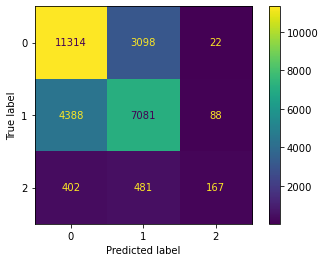

In [22]:
cm = confusion_matrix(y_test_2, predictions_2, labels=rf_sub_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_2.classes_)
disp.plot()

plt.show()

In [23]:
subgroup_2_predictions = rf_sub_2.predict(subgroup_2.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [24]:
subgroup_2['predictions'] = subgroup_2_predictions

/tmp/ipykernel_3194/1303998233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgroup_2['predictions'] = subgroup_2_predictions


In [25]:
print(sum(rf_sub_2.predict(X_test) == y_test)/len(y_test))

0.6864391109796235


In [26]:
subgroup_2_return_df = subgroup_2.merge(all_subgroups[all_subgroups['subgroup'] == 2], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [27]:
subgroup_2_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
       'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
       'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
       'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_2_predictions.csv')

In [28]:
subgroup_3_sample = subgroup_3.sample(frac = 0.5)

In [29]:
#subgroup 3
X = subgroup_3_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_3_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_3 = RandomForestClassifier(bootstrap = True,
 max_depth = 100,
 max_features =  'auto',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  600)
rf_sub_3.fit(X_train, y_train)
predictions_3 = rf_sub_3.predict(X_test)
y_test_3 = y_test
print(sum(rf_sub_3.predict(X_test) == y_test)/len(y_test))

0.7311333661686642


In [30]:
rf_sub_3.feature_importances_

array([0.1255886 , 0.13503336, 0.11056227, 0.06982373, 0.12647168,
       0.04202499, 0.17910199, 0.21139339])

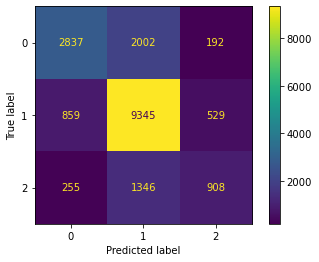

In [30]:
cm = confusion_matrix(y_test_3, predictions_3, labels=rf_sub_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_3.classes_)
disp.plot()

plt.show()

In [31]:
subgroup_3_predictions = rf_sub_3.predict(subgroup_3.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [32]:
subgroup_3['predictions'] = subgroup_3_predictions

/tmp/ipykernel_3194/2861471179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgroup_3['predictions'] = subgroup_3_predictions


In [33]:
print(sum(rf_sub_3.predict(X_test) == y_test)/len(y_test))

0.7163574673014831


In [34]:
subgroup_3_return_df = subgroup_3.merge(all_subgroups[all_subgroups['subgroup'] == 3], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [35]:
subgroup_3_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
       'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
       'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
       'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_3_predictions.csv')

In [31]:
subgroup_4_sample = subgroup_4.sample(frac = 0.2)

In [32]:
subgroup_4_sample

,subject_id,hadm_id,subgroup,rounded_age,Combined_Blood_Pressure,charttime,Final_Temperature_F,heart_rate,RespiratoryRate_combined,SpO2,date,hadm_number,hours_in_hospital,sofa,group
400606,7326,149062,4,64,149.0,2119-05-12 15:00:00,97.400002,59.0,11.0,97.0,2119-05-12,2,6,1,0
1415569,26793,116380,4,68,122.0,2135-02-01 16:00:00,100.220003,96.0,12.0,99.0,2135-02-01,1,5,1,0
755959,14321,151860,4,73,118.0,2119-09-14 02:00:00,99.320003,88.0,10.0,93.0,2119-09-14,1,37,4,0
1147683,21867,175298,4,68,143.0,2146-08-07 22:00:00,97.700000,64.0,29.0,96.0,2146-08-07,1,48,5,1
131873,2349,132788,4,50,150.0,2161-07-29 19:00:00,100.500079,111.0,17.0,100.0,2161-07-29,2,60,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609773,31665,156663,4,59,92.0,2196-09-03 13:00:00,99.900002,78.0,18.0,98.0,2196-09-03,1,360,2,0
1112436,21035,121418,4,84,131.0,2176-12-13 04:00:00,99.100043,83.0,19.0,99.0,2176-12-13,1,35,0,0
98549,1718,121066,4,46,115.0,2121-10-19 12:00:00,99.139999,72.0,18.0,100.0,2121-10-19,1,116,0,0
1647647,32678,187633,4,84,127.0,2192-05-23 22:00:00,98.239999,90.0,13.0,96.0,2192-05-23,1,8,2,0


In [33]:
#subgroup 4
X = subgroup_4_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_4_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_4 = RandomForestClassifier(bootstrap = True,
 max_depth = 90,
 max_features =  'auto',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_4.fit(X_train, y_train)
predictions_4 = rf_sub_4.predict(X_test)
y_test_4 = y_test
print(sum(rf_sub_4.predict(X_test) == y_test)/len(y_test))

0.7137519142419602


In [34]:
rf_sub_4.feature_importances_

array([0.14314055, 0.14004033, 0.11871163, 0.07142489, 0.14811786,
       0.0299842 , 0.18032638, 0.16825416])

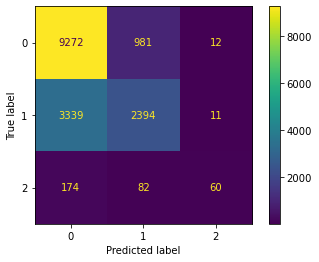

In [47]:
cm = confusion_matrix(y_test_4, predictions_4, labels=rf_sub_4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_4.classes_)
disp.plot()

plt.show()

In [48]:
subgroup_4_predictions = rf_sub_4.predict(subgroup_4.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [49]:
subgroup_4['predictions'] = subgroup_4_predictions

/tmp/ipykernel_2630/919164771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgroup_4['predictions'] = subgroup_4_predictions


In [50]:
print(sum(rf_sub_4.predict(X_test) == y_test)/len(y_test))

0.7182848392036754


In [51]:
subgroup_4_return_df = subgroup_4.merge(all_subgroups[all_subgroups['subgroup'] == 4], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [52]:
subgroup_4

,subject_id,hadm_id,subgroup,rounded_age,Combined_Blood_Pressure,charttime,Final_Temperature_F,heart_rate,RespiratoryRate_combined,SpO2,date,hadm_number,hours_in_hospital,sofa,group,predictions
102,6,107064,4,66,134.0,2175-05-30 20:30:00,96.800003,87.0,13.0,99.0,2175-05-30,1,0,4,0,0
103,6,107064,4,66,141.0,2175-05-30 23:00:00,97.800079,84.0,14.0,100.0,2175-05-30,1,2,4,0,0
104,6,107064,4,66,147.0,2175-05-31 02:00:00,97.100057,79.0,11.0,100.0,2175-05-31,1,5,4,0,0
105,6,107064,4,66,146.0,2175-05-31 07:00:00,96.900079,76.0,9.0,100.0,2175-05-31,1,10,4,0,0
106,6,107064,4,66,130.0,2175-05-31 11:00:00,97.599998,85.0,13.0,100.0,2175-05-31,1,14,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653768,32798,187802,4,56,137.0,2108-03-08 11:40:00,97.700000,89.0,21.0,96.0,2108-03-08,1,155,0,0,0
1653769,32798,187802,4,56,124.0,2108-03-08 16:00:00,98.200043,89.0,29.0,96.0,2108-03-08,1,160,0,0,1
1653770,32798,187802,4,56,113.0,2108-03-08 20:00:00,98.800003,79.0,22.0,90.0,2108-03-08,1,164,0,0,0
1653771,32798,187802,4,56,128.0,2108-03-09 00:00:00,97.400002,81.0,26.0,94.0,2108-03-09,1,168,0,0,0


In [53]:
subgroup_4_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
       'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
       'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
       'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_4_predictions.csv')

In [35]:
subgroup_5_sample = subgroup_5.sample(frac = 0.4)


In [36]:
#subgroup 5
X = subgroup_5_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_5_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_5 = RandomForestClassifier(bootstrap = True,
 max_depth = 1000,
 max_features =  'sqrt',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_5.fit(X_train, y_train)
predictions_5 = rf_sub_5.predict(X_test)
y_test_5 = y_test
print(sum(rf_sub_5.predict(X_test) == y_test)/len(y_test))





0.7994203598599203


In [37]:
rf_sub_5.feature_importances_

array([0.11729278, 0.12148392, 0.0924749 , 0.05947278, 0.12858393,
       0.0303584 , 0.25130311, 0.19903016])

In [56]:
subgroup_5_predictions = rf_sub_5.predict(subgroup_5.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

subgroup_5['predictions'] = subgroup_5_predictions

subgroup_5_return_df = subgroup_5.merge(all_subgroups[all_subgroups['subgroup'] == 5], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

subgroup_5_return_df

/tmp/ipykernel_2630/3714573649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgroup_5['predictions'] = subgroup_5_predictions


,subject_id,hadm_id,subgroup_x,rounded_age,Combined_Blood_Pressure,charttime,Final_Temperature_F,heart_rate,RespiratoryRate_combined,SpO2,...,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression,age,subgroup_y
0,17,161087,5,48,126.0,2135-05-09 14:45:00,97.879997,85.0,12.0,100.0,...,0,0,0,0,0,0,0,1,48,5
1,17,161087,5,48,126.0,2135-05-09 15:00:00,98.060001,96.0,12.0,100.0,...,0,0,0,0,0,0,0,1,48,5
2,17,161087,5,48,122.0,2135-05-09 15:15:00,98.420003,90.0,12.0,100.0,...,0,0,0,0,0,0,0,1,48,5
3,17,161087,5,48,113.0,2135-05-09 15:30:00,98.600000,97.0,12.0,100.0,...,0,0,0,0,0,0,0,1,48,5
4,17,161087,5,48,111.0,2135-05-09 15:45:00,98.600000,95.0,12.0,100.0,...,0,0,0,0,0,0,0,1,48,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442243,32810,189751,5,22,146.0,2100-10-04 19:00:00,100.599998,114.0,28.0,97.0,...,1,1,0,0,0,0,0,0,22,5
442244,32810,189751,5,22,162.0,2100-10-04 23:00:00,103.400057,111.0,30.0,97.0,...,1,1,0,0,0,0,0,0,22,5
442245,32810,189751,5,22,142.0,2100-10-05 03:00:00,100.900043,130.0,29.0,98.0,...,1,1,0,0,0,0,0,0,22,5
442246,32810,189751,5,22,154.0,2100-10-05 07:00:00,101.900002,99.0,27.0,97.0,...,1,1,0,0,0,0,0,0,22,5


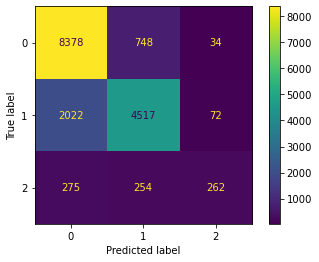

In [57]:
cm = confusion_matrix(y_test_5, predictions_5, labels=rf_sub_5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_5.classes_)
disp.plot()

plt.show()

In [58]:
subgroup_5_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
       'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
       'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
       'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_5_predictions.csv')

In [38]:
subgroup_6_sample = subgroup_6.sample(frac = 0.4)

In [39]:
#subgroup 6 
X = subgroup_6_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_6_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_6 = RandomForestClassifier(bootstrap = True,
 max_depth = 500,
 max_features =  'sqrt',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_6.fit(X_train, y_train)
predictions_6 = rf_sub_6.predict(X_test)
y_test_6 = y_test
print(sum(rf_sub_6.predict(X_test) == y_test)/len(y_test))

0.7314337355802456


In [40]:
rf_sub_6.feature_importances_

array([0.13694588, 0.13070791, 0.11020904, 0.071431  , 0.13197463,
       0.0532046 , 0.18363582, 0.18189113])

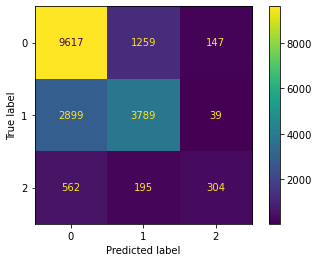

In [61]:
cm = confusion_matrix(y_test_6, predictions_6, labels=rf_sub_6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_6.classes_)
disp.plot()

plt.show()

In [62]:
subgroup_6_predictions = rf_sub_6.predict(subgroup_6.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [63]:
subgroup_6['predictions'] = subgroup_6_predictions

/tmp/ipykernel_2630/1105542993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgroup_6['predictions'] = subgroup_6_predictions


In [64]:
subgroup_6_return_df = subgroup_6.merge(all_subgroups[all_subgroups['subgroup'] == 6], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [81]:
subgroup_6

,subject_id,hadm_id,subgroup,rounded_age,Combined_Blood_Pressure,charttime,Final_Temperature_F,heart_rate,RespiratoryRate_combined,SpO2,date,hadm_number,hours_in_hospital,sofa,group,predictions
0,3,145834,6,77,99.0,2101-10-21 01:00:00,98.200043,141.0,0.0,97.0,2101-10-21,1,0,7,1,1
1,3,145834,6,77,124.0,2101-10-21 02:00:00,97.160004,117.0,18.0,100.0,2101-10-21,1,1,7,1,0
2,3,145834,6,77,129.0,2101-10-21 03:00:00,97.700000,114.0,18.0,100.0,2101-10-21,1,2,7,1,0
3,3,145834,6,77,122.0,2101-10-21 04:00:00,97.879997,116.0,0.0,98.0,2101-10-21,1,3,7,1,1
4,3,145834,6,77,114.0,2101-10-21 05:00:00,97.879997,108.0,0.0,100.0,2101-10-21,1,4,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651346,32768,106201,6,61,176.0,2170-02-27 08:00:00,99.400002,69.0,21.0,93.0,2170-02-27,1,104,4,0,0
1651347,32768,106201,6,61,178.0,2170-02-27 12:00:00,99.000000,75.0,21.0,96.0,2170-02-27,1,108,4,0,0
1651348,32768,106201,6,61,175.0,2170-02-27 16:00:00,99.100043,91.0,19.0,96.0,2170-02-27,1,112,4,0,0
1651349,32768,106201,6,61,152.0,2170-02-27 20:00:00,99.000000,66.0,19.0,96.0,2170-02-27,1,116,4,0,0


In [65]:
subgroup_6_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
       'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
       'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
       'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_6_predictions.csv')

In [41]:
subgroup_7_sample =subgroup_7.sample(frac = 0.9)

In [ ]:
#subgroup 7 
X = subgroup_7.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_7['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_7 = RandomForestClassifier(bootstrap = True,
 max_depth = 1000,
 max_features =  'auto',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_7.fit(X_train, y_train)
predictions_7 = rf_sub_7.predict(X_test)
y_test_7 = y_test
print(sum(rf_sub_7.predict(X_test) == y_test)/len(y_test))

In [ ]:
rf_sub_7.feature_importances_

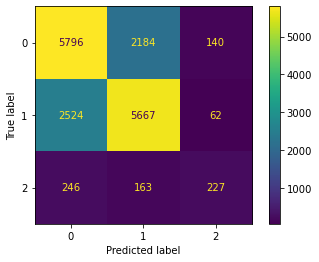

In [68]:
cm = confusion_matrix(y_test_7, predictions_7, labels=rf_sub_7.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_7.classes_)
disp.plot()

plt.show()

In [69]:
subgroup_7_predictions = rf_sub_7.predict(subgroup_7.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [70]:
subgroup_7['predictions'] = subgroup_7_predictions

/tmp/ipykernel_2630/1464725400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgroup_7['predictions'] = subgroup_7_predictions


In [71]:
subgroup_7_return_df = subgroup_7.merge(all_subgroups[all_subgroups['subgroup'] == 7], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [79]:
subgroup_7

,subject_id,hadm_id,subgroup,rounded_age,Combined_Blood_Pressure,charttime,Final_Temperature_F,heart_rate,RespiratoryRate_combined,SpO2,date,hadm_number,hours_in_hospital,sofa,group,predictions
713,36,122659,7,70,97.0,2131-05-16 23:45:00,99.139999,117.0,21.0,100.0,2131-05-16,1,0,2,0,0
714,36,122659,7,70,94.0,2131-05-17 00:00:00,99.139999,119.0,18.0,98.0,2131-05-17,1,0,2,0,0
715,36,122659,7,70,91.0,2131-05-17 01:30:00,98.960001,114.0,20.0,98.0,2131-05-17,1,1,2,0,0
716,36,122659,7,70,89.0,2131-05-17 02:00:00,98.960001,115.0,23.0,98.0,2131-05-17,1,2,2,0,0
717,36,122659,7,70,103.0,2131-05-17 06:15:00,96.620003,81.0,16.0,100.0,2131-05-17,1,6,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655995,32809,101254,7,72,126.0,2135-09-01 19:00:00,100.000043,95.0,31.0,95.0,2135-09-01,1,10,0,0,0
1655996,32809,101254,7,72,113.0,2135-09-01 23:00:00,98.200043,78.0,26.0,98.0,2135-09-01,1,14,0,0,0
1655997,32809,101254,7,72,132.0,2135-09-02 03:00:00,100.099998,92.0,26.0,95.0,2135-09-02,1,18,0,0,0
1655998,32809,101254,7,72,110.0,2135-09-02 07:00:00,98.300003,93.0,25.0,96.0,2135-09-02,1,22,0,0,0


In [72]:
subgroup_7_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
       'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
       'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
       'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_7_predictions.csv')